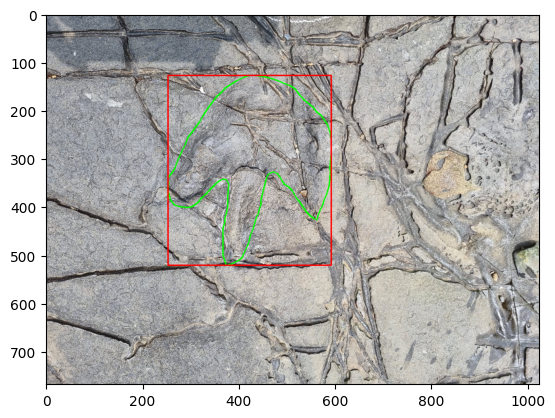

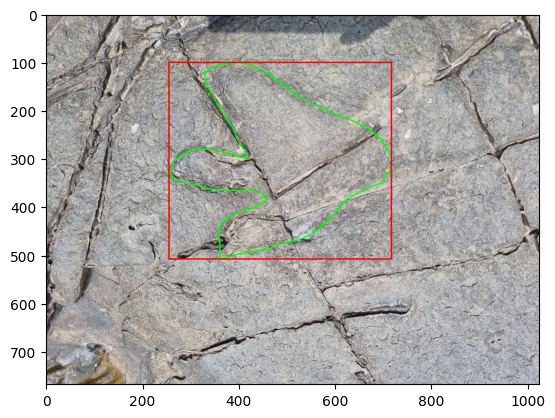

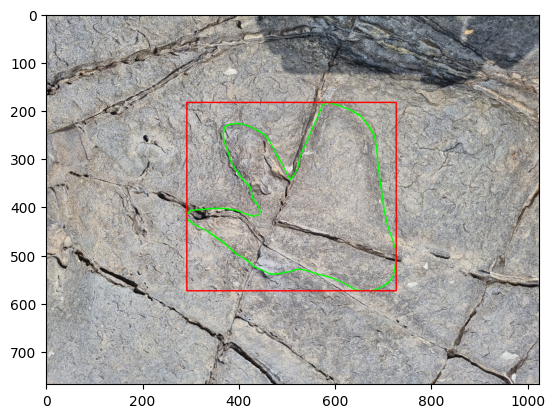

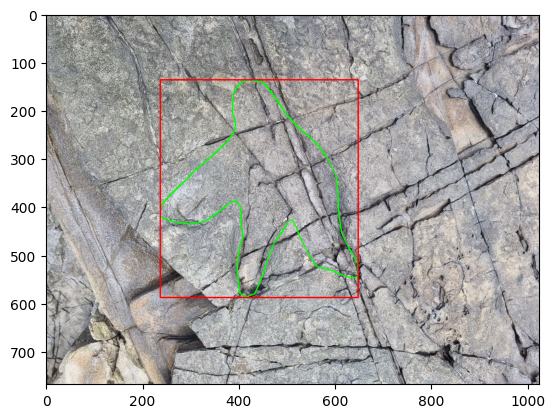

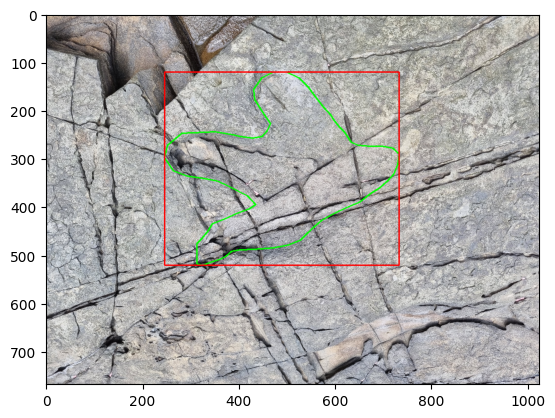

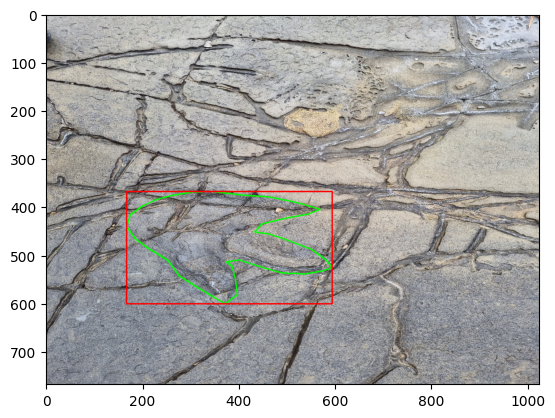

KeyboardInterrupt: 

In [3]:
import json # shit + alt + f
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt


json_dir = './dino/anno'
json_paths = glob.glob(os.path.join(json_dir, "*.json"))

label_dict = {"수각류": 0}

for json_path in json_paths:
    with open(json_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    images_info = json_data["images"]
    annotations_info = json_data["annotations"] # list > for문

    file_name: str = images_info["filename"] # 변수명: type = 변수 type 지정
    image_id = images_info["id"]
    image_width = images_info["width"]
    image_height = images_info["height"]

    # category_name = str(annotations_info[category_name])
    # dictionary in list "category_name" key가 있는지 확인하여 추출

    # image_ratio = ()
    new_width = 1024
    new_height = 768
    image_counter = 0

    for i, anno_info in enumerate(annotations_info):
        if image_counter >= 5:  # 이미지 카운터가 5에 도달하면 루프를 종료
            break
        

        if image_id == anno_info["image_id"]:
            image_path = os.path.join("./dino/dino_images", file_name)
            image = cv2.imread(image_path)
            # print(image)

            h, w, c = image.shape

            scale_x = new_width / image.shape[1] # w
            scale_y = new_height / image.shape[0] # h

            resized_image = cv2.resize(image, (new_width, new_height))
            # src: 원본 이미지 (numpy array 형태), dsize: 출력 이미지의 원하는 크기. (width, height) 튜플로 표시
    
            category_name = anno_info["category_name"]
            polygons = anno_info["polygon"]
            ''' resized_image를 통해 1024 x 768로 변환했지만, polygon 좌표는 원본 이미지에 맞춰져 있어서
                사용하기 어렵기 때문에 따로 축소 비율에 맞춰 바꿔줘야 함'''

            points = []

            for polygon_info in polygons:
                x = polygon_info['x']
                y = polygon_info['y']

                resized_x = int(x * scale_x)
                resized_y = int(y * scale_y)

                points.append((resized_x, resized_y))
    
            cv2.polylines(resized_image, 
                          [np.array(points, np.int32).reshape((-1, 1, 2))],
                          isClosed=True,
                          color=(0,255,0),
                          thickness=2)
            
            
            '''cv2.polylines(img, pts, ...)
               img: 다각선을 그릴 이미지.
               pts: 다각선의 꼭짓점들을 담은 numpy 배열의 리스트. 각 numpy 배열은 다각선의 꼭짓점 좌표를 담고 있습니다.
               isClosed: 다각선이 닫힌 형태인지 여부를 지정하는 불리언 값. True이면 마지막 꼭짓점과 첫 번째 꼭짓점을 연결하는 선을 그립니다.
                (default = True)


                np.array(points, np.int32):
                points: 파이썬 리스트 또는 튜플, 각 요소는 (x, y) 형태의 튜플 또는 리스트일 수 있습니다.
                np.int32: 배열의 데이터 유형을 정수 유형으로 지정합니다.
                이 단계에서는 points 리스트를 np.int32 데이터 유형을 가진 NumPy 배열로 변환합니다.
                .reshape((-1, 1, 2)):

                reshape 함수를 사용하여 배열의 형태를 변경합니다.
                (-1, 1, 2) 형태의 튜플을 전달하여 배열의 차원을 변경합니다. 여기서:
                -1: 이 차원의 크기를 자동으로 계산하여 원래 배열의 요소 수를 유지합니다.
                1: 두 번째 차원에 대한 크기를 1로 설정합니다.
                2: 세 번째 차원에 대한 크기를 2로 설정합니다.
                결과적으로, 각 포인트 (x, y)는 자체 2D 배열 내에 위치하게 됩니다.'''
    
            x_coords = [point[0] for point in points] # 리스트 내 첫 번째 인자(x)
            y_coords = [point[1] for point in points] # 리스트 내 두 번째 인자(y)

            x_min = min(x_coords)
            y_min = min(y_coords)
            x_max = max(x_coords)
            y_max = max(y_coords)

            cv2.rectangle(resized_image, 
                          (x_min, y_min), (x_max, y_max),
                          color=(0, 0, 255),
                          thickness=2)

            resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
            plt.imshow(resized_image_rgb)
            plt.show()   
        
            image_counter += 1
 

            # cv2.imshow("", resized_image)
            # key = cv2.waitKey()
            # if key == ord('q'):
            #    exit()
            
            center_x = ((x_max + x_min) / (2 * new_width))
            center_y = ((y_max + y_min) / (2 * new_height))

            yolo_w = (x_max - x_min) / new_width
            yolo_h = (y_max - y_min) / new_height

            # print(f"{center_x}, {center_y}, {yolo_w}, {yolo_h}")
            # exit()

            image_name_temp = file_name.replace(".jpg", "") # .jpg 제외 저장
            # yolo format .jpg > .txt
            label_number = label_dict[category_name]
            # yolo format (label) {center_x} {center_y} ...

           
# temp_string = "C_TP_15.jpg"
# temp_string.split(".") > C_TP_15

        
        os.makedirs("./yolo_label_data", exist_ok=True)
        with open(f"./yolo_label_data/{image_name_temp}.txt", "a") as f:
            f.write(f"{label_number} {center_x} {center_y} {yolo_w} {yolo_h}\n")  # 줄 바꿈 추가
        

    ''' Debug: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
            Solution: pip uninstall opencv-python
            PermissionError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\LG\\AppData\\Local\\Temp\\pip-uninstall-tf3i1s63\\cv2.pyd'
            관리자 권한 재실행 하여 삭제 진행
            pip install opencv-python==4.7.0.72 설치 
            > 동일 문제로 matplotlib 사용 '''
    # print(f"width : {image_width}, height : {image_height}")
    # exit()